<a href="https://colab.research.google.com/github/sheharyarakhtar/quantjourney/blob/main/FFT_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas import Timedelta


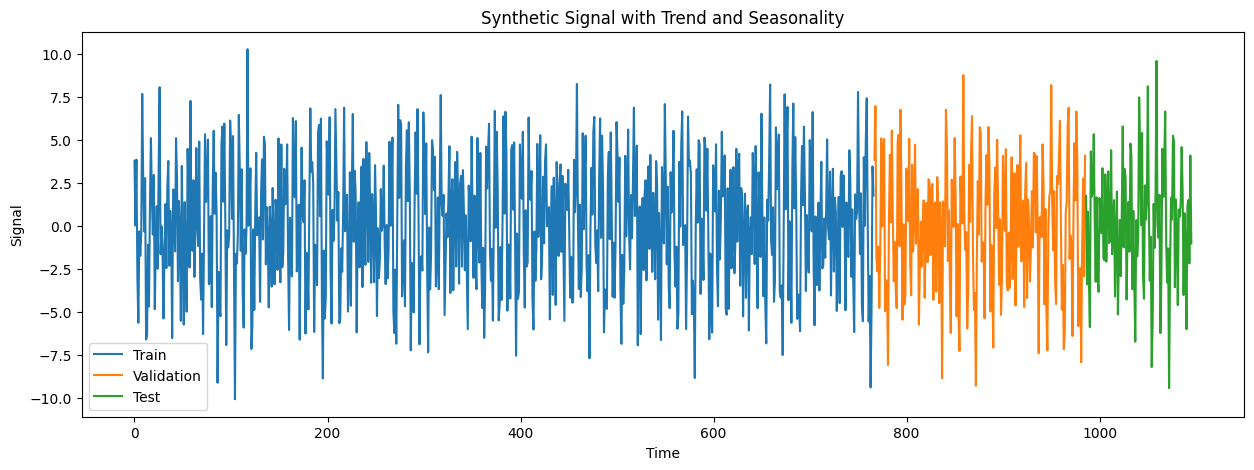

In [ ]:
synthetic = True
end_date = '2025-06-03'
days = 365*3
start_date = pd.to_datetime(end_date) - pd.Timedelta(days=days)
ticker = 'AAPL'


def generate_synthetic_data(n_days=365):
    t = np.linspace(0, n_days, n_days)

    f11 = 20
    f12 = 40
    f21 = 60
    f22 = 80

    a11 = 1.1
    a12 = 2.1
    a21 = 3.5
    a22 = 2.5


    trend = 0 * t
    yearly_pattern = a11 * np.sin(f11 * 2 * np.pi * t / 365) + a12 * np.cos(f12 * 2 * np.pi * t / 365)
    quarterly_pattern = a21 * np.sin(f21 * 2 * np.pi * t / 91) + a22 * np.cos(f22 * 2 * np.pi * t / 91)
    noise = np.random.normal(0, 1, n_days)

    signal = trend + yearly_pattern + quarterly_pattern + noise
    return t, signal
if synthetic:
    t, signal = generate_synthetic_data(days)
else:
    data = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False)
    data['Close'] = np.log(data['Close'])
    data['Open'] = np.log(data['Open'])
    data['pct_change'] = (data['Close'] - data['Open'])*100/(data['Open'])
    signal = data['pct_change']
    t= [i for i in range(len(signal))]

def split_data(signal, train_ratio=0.7, validation_ratio=0.2):
    """
    Split signal data into train/validation/test sets

    Args:
        signal: Array containing the signal data
        train_ratio: Proportion of data for training (default 0.7)
        validation_ratio: Proportion of data for validation (default 0.2)

    Returns:
        train, validation, test: The split datasets
    """
    train_size = int(len(signal) * train_ratio)
    validation_size = int(len(signal) * validation_ratio)

    train = signal[:train_size]
    validation = signal[train_size:train_size+validation_size]
    test = signal[train_size+validation_size:]

    return train, validation, test, train_size, validation_size

def plot_splits(t, train, validation, test, train_size, validation_size, title):
    """
    Plot the train/validation/test splits of the data

    Args:
        t: Array containing time points
        train: Training data array
        validation: Validation data array
        test: Test data array
        train_size: Size of training set
        validation_size: Size of validation set
    """
    plt.figure(figsize=(15, 5))
    plt.plot(t[:train_size], train, label='Train')
    plt.plot(t[train_size:train_size+validation_size], validation, label='Validation')
    plt.plot(t[train_size+validation_size:], test, label='Test')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()
    plt.show()
title = 'Synthetic Signal with Trend and Seasonality' if synthetic else f'{ticker} Signal'
# Split and plot the data
train, validation, test, train_size, validation_size = split_data(signal, train_ratio=0.7, validation_ratio=0.2)
plot_splits(t, train, validation, test, train_size, validation_size, title = title)

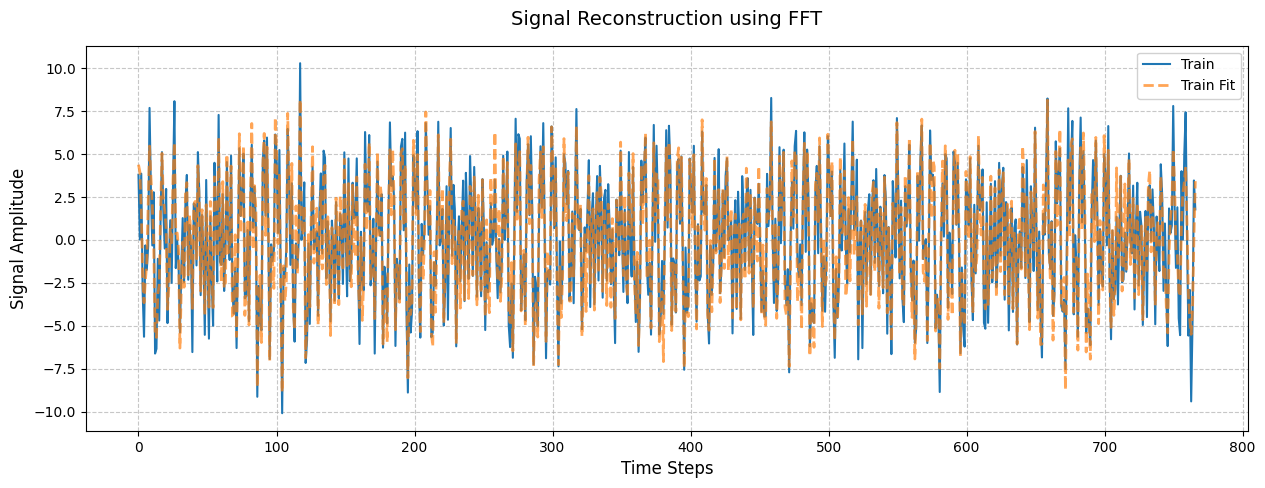

In [ ]:
# Train
fft_vals = np.fft.fft(train)
magnitudes = np.abs(fft_vals)
frequencies = np.fft.fftfreq(len(train), d = 1)
df = pd.DataFrame({'FFT': fft_vals, 'frequency': frequencies, 'magnitude': magnitudes}).sort_values(by='magnitude', ascending=False)
df = df[df.magnitude > 0]
fft_denoised = np.zeros_like(fft_vals)
top_n = df.sort_values('magnitude', ascending=False).head(25)
fft_denoised[top_n.index] = fft_vals[top_n.index]
denoised_signal = np.fft.ifft(fft_denoised)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Create main figure and axis
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(111)

# Plot main data
ax.plot(t[:train_size], train, label='Train')
ax.plot(t[:train_size], denoised_signal, label='Train Fit', linewidth=2, linestyle='--', alpha=0.7)
ax.set_title('Signal Reconstruction using FFT', fontsize=14, pad=15)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Signal Amplitude', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10, loc='best', framealpha=0.9)

Best N: 5
Best RMSE: 2.3699


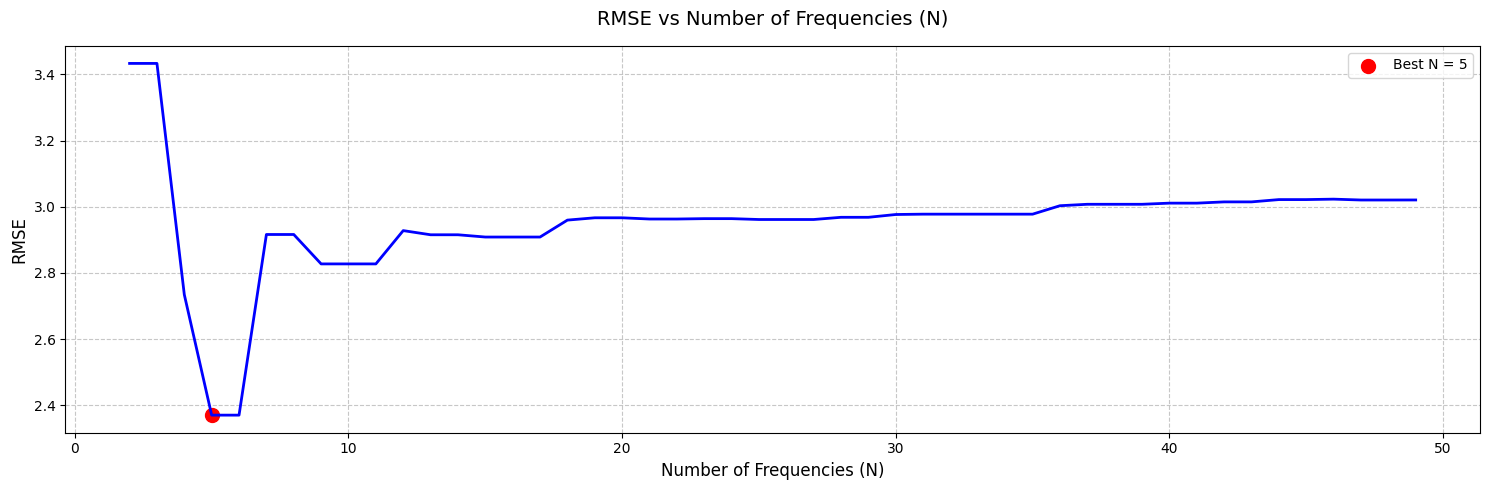

In [ ]:
t_future = np.linspace(t[0], len(train)+len(validation), len(train) + len(validation))

# Calculate RMSE for different values of N
best_rmse = float('inf')
best_N = 0
n_values = []
rmse_values = []

# Try different values of N from 1 to 100
for N in range(2, 50):
    # Get top N frequencies
    top_n = df.sort_values('magnitude', ascending=False).head(N)

    # Reconstruct signal for validation period
    reconstructed = np.zeros_like(t_future, dtype=float)
    for idx in top_n.index:
        freq = frequencies[idx]
        coeff = fft_vals[idx]

        if freq > 0:
            amplitude = 2 * np.abs(coeff) / len(signal)
            phase = np.angle(coeff)
            reconstructed += amplitude * np.cos(2 * np.pi * freq * t_future + phase)

    # Add DC component
    dc_idx = np.where(frequencies == 0)[0][0]
    reconstructed += np.abs(fft_vals[dc_idx]) / len(signal)

    # Calculate RMSE on validation set
    validation_pred = reconstructed[len(train):]
    rmse = np.sqrt(np.mean((validation - validation_pred) ** 2))

    # Store values for plotting
    n_values.append(N)
    rmse_values.append(rmse)

    # Update best N if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_N = N

print(f"Best N: {best_N}")
print(f"Best RMSE: {best_rmse:.4f}")

# Plot RMSE vs N
plt.figure(figsize=(15, 5))
plt.plot(n_values, rmse_values, 'b-', linewidth=2)
plt.scatter([best_N], [best_rmse], color='red', s=100, label=f'Best N = {best_N}')

plt.title('RMSE vs Number of Frequencies (N)', fontsize=14, pad=15)
plt.xlabel('Number of Frequencies (N)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='best')

# Set tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()



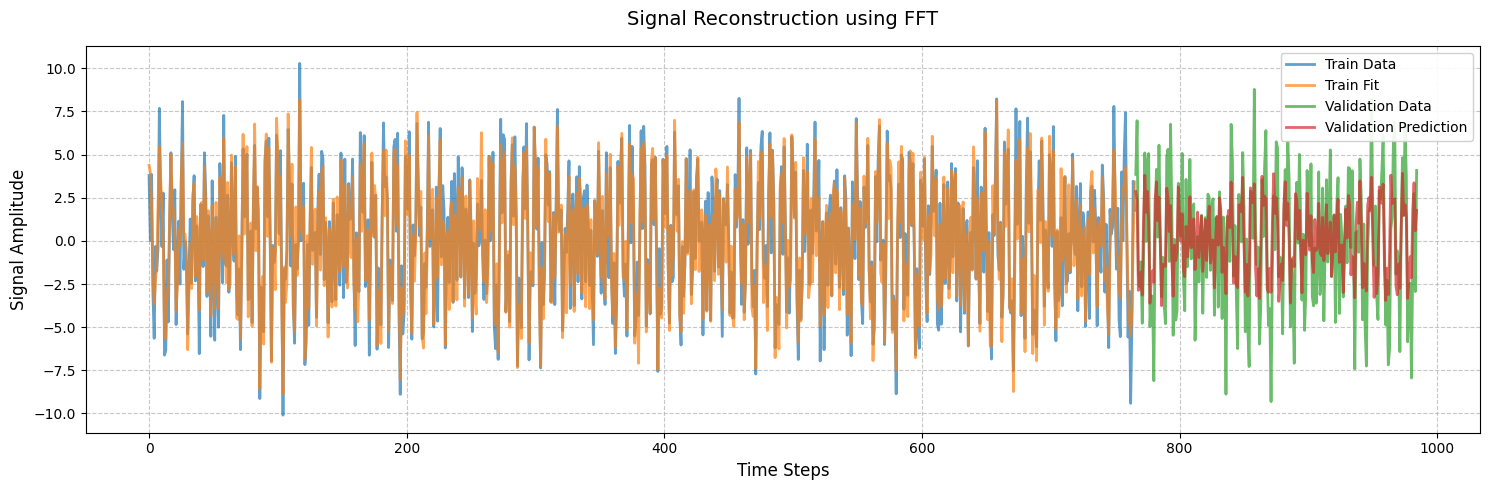

In [ ]:
# Validation
K = 5
top_n = df.sort_values('magnitude', ascending=False).head(K)
reconstructed = np.zeros_like(t_future, dtype=float)
for idx in top_n.index:
    freq = frequencies[idx]
    coeff = fft_vals[idx]

    if freq > 0:
        amplitude = 2 * np.abs(coeff) / len(signal)  # Normalize and scale
        phase = np.angle(coeff)
        reconstructed += amplitude * np.cos(2 * np.pi * freq * t_future + phase)
    # Add the DC component (mean value)
dc_idx = np.where(frequencies == 0)[0][0]
reconstructed += np.abs(fft_vals[dc_idx]) / len(signal)


plt.figure(figsize=(15, 5))
plt.plot(range(len(train)), train, label='Train Data', linewidth=2, alpha=0.7)
plt.plot(range(len(train)), denoised_signal, label='Train Fit', linewidth=2, linestyle='-', alpha=0.7)
plt.plot(range(train_size, train_size+validation_size), validation, label='Validation Data', linewidth=2, alpha=0.7)
plt.plot(range(train_size, train_size+validation_size), reconstructed[len(train):], label='Validation Prediction', linewidth=2,  alpha=0.7)

plt.title('Signal Reconstruction using FFT', fontsize=14, pad=15)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Signal Amplitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='best', framealpha=0.9)

# Set tick parameters
plt.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

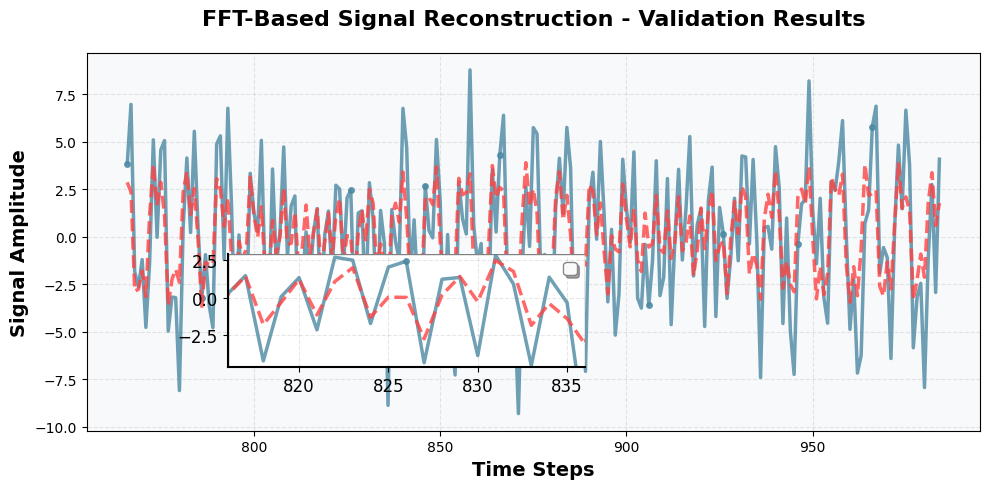

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(range(len(train)), train, label='Train Data', linewidth=2, alpha=0.7)
# plt.plot(range(len(train)), denoised_signal, label='Train Fit', linewidth=2, linestyle='-', alpha=0.7)
# Custom colors for better visualization
validation_color = '#4B88A2'  # Steel blue
prediction_color = '#FF4242'  # Bright red

plt.plot(range(train_size, train_size+validation_size),
         validation,
         label='Validation Data',
         color=validation_color,
         linewidth=2.5,
         alpha=0.8,
         marker='o',
         markersize=4,
         markevery=20)

plt.plot(range(train_size, train_size+validation_size),
         reconstructed[len(train):],
         label='Validation Prediction',
         color=prediction_color,
         linewidth=2.5,
         alpha=0.8,
         linestyle='--')

plt.title('FFT-Based Signal Reconstruction - Validation Results',
         fontsize=16,
         pad=20,
         fontweight='bold')
plt.xlabel('Time Steps', fontsize=14, fontweight='semibold')
plt.ylabel('Signal Amplitude', fontsize=14, fontweight='semibold')

# Enhanced grid and background
plt.grid(True, linestyle='--', alpha=0.3)
plt.gca().set_facecolor('#f8f9fa')

# Add zoomed inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create inset axes
axins = inset_axes(plt.gca(),
                   width="40%",
                   height="30%",
                   loc='lower left',
                   bbox_to_anchor=(0.15, 0.15, 1, 1),
                   bbox_transform=plt.gca().transAxes)

# Plot the same data on the inset
axins.plot(range(train_size, train_size+validation_size),
          validation,
          color=validation_color,
          linewidth=2.5,
          alpha=0.8,
          marker='o',
          markersize=4,
          markevery=20)

axins.plot(range(train_size, train_size+validation_size),
          reconstructed[len(train):],
          color=prediction_color,
          linewidth=2.5,
          alpha=0.8,
          linestyle='--')

# Set the zoom limits - adjust these values as needed
x1, x2 = train_size + 50, train_size + 70  # Zoom x range
y1 = min(validation[50:70].min(), reconstructed[len(train)+50:len(train)+70].min()) - 0.1
y2 = max(validation[50:70].max(), reconstructed[len(train)+50:len(train)+70].max()) + 0.1

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Add connecting lines between the zoomed region and the inset
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Style the inset
axins.grid(True, linestyle='--', alpha=0.3)
axins.tick_params(labelsize=8)

# Improved legend
plt.legend(fontsize=12,
          loc='upper right',
          framealpha=0.95,
          facecolor='white',
          edgecolor='gray',
          shadow=True)

# Set tick parameters with enhanced visibility
plt.tick_params(axis='both', which='major', labelsize=12)

# Add a subtle border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

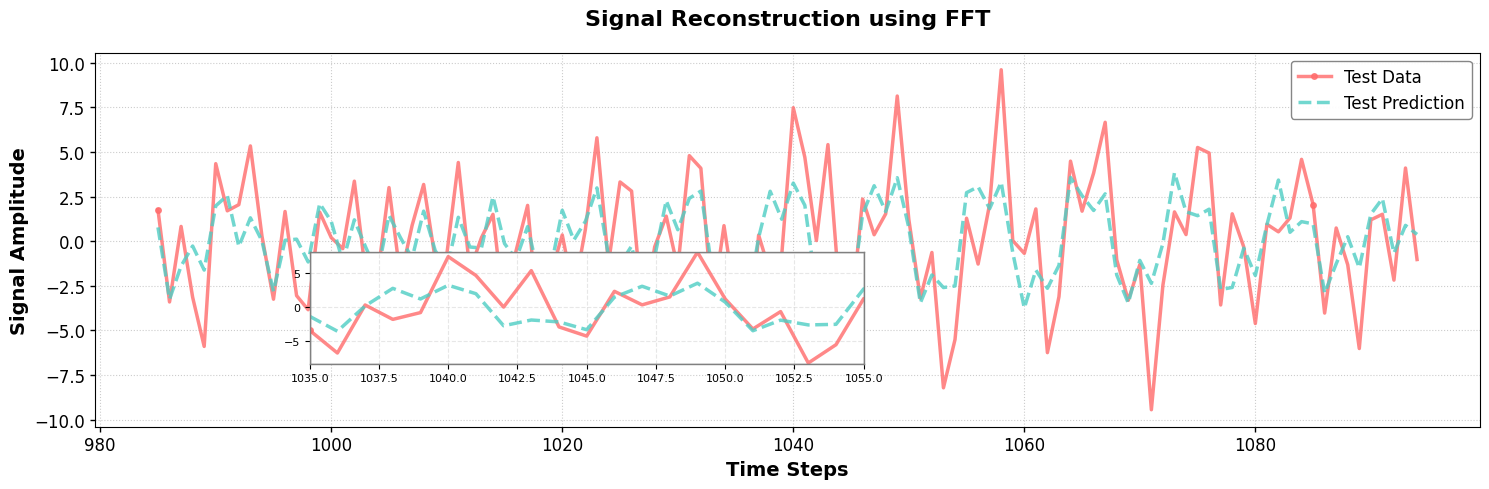

In [ ]:
top_n = df.sort_values('magnitude', ascending=False).head(K)

t_future = np.linspace(t[0], len(train)+len(validation)+len(test), len(train) + len(validation) + len(test))

reconstructed = np.zeros_like(t_future, dtype=float)
for idx in top_n.index:
    freq = frequencies[idx]
    coeff = fft_vals[idx]

    if freq > 0:
        amplitude = 2 * np.abs(coeff) / len(signal)  # Normalize and scale
        phase = np.angle(coeff)
        reconstructed += amplitude * np.cos(2 * np.pi * freq * t_future + phase)
    # Add the DC component (mean value)
dc_idx = np.where(frequencies == 0)[0][0]
reconstructed += np.abs(fft_vals[dc_idx]) / len(signal)


plt.figure(figsize=(15, 5))
# Custom colors for a modern look
test_color = '#FF6B6B'  # Coral red
pred_color = '#4ECDC4'  # Turquoise

# Create the plot with enhanced styling
plt.plot(range(train_size+validation_size, train_size+validation_size+len(test)),
         test,
         label='Test Data',
         color=test_color,
         linewidth=2.5,
         alpha=0.8,
         marker='o',
         markersize=4,
         markevery=50)

plt.plot(range(train_size+validation_size, train_size+validation_size+len(test)),
         reconstructed[len(train)+len(validation):],
         label='Test Prediction',
         color=pred_color,
         linewidth=2.5,
         alpha=0.8,
         linestyle='--')

plt.title('Signal Reconstruction using FFT',
         fontsize=16,
         pad=20,
         fontweight='bold')

plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Signal Amplitude', fontsize=14, fontweight='bold')

# Enhanced grid
plt.grid(True, linestyle=':', alpha=0.4, color='gray')

# Enhanced legend
legend = plt.legend(fontsize=12,
          loc='upper right',
          framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')

# Set tick parameters with enhanced visibility
plt.tick_params(axis='both', which='major', labelsize=12, width=1)

# Add zoomed inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Create inset axes
axins = inset_axes(plt.gca(),
                   width="40%",
                   height="30%",
                   loc='lower left',
                   bbox_to_anchor=(0.15, 0.15, 1, 1),
                   bbox_transform=plt.gca().transAxes)

# Plot the same data on the inset
axins.plot(range(train_size+validation_size, train_size+validation_size+len(test)),
          test,
          color=test_color,
          linewidth=2.5,
          alpha=0.8,
          marker='o',
          markersize=4,
          markevery=50)

axins.plot(range(train_size+validation_size, train_size+validation_size+len(test)),
          reconstructed[len(train)+len(validation):],
          color=pred_color,
          linewidth=2.5,
          alpha=0.8,
          linestyle='--')

# Set the zoom limits - adjust these values as needed
x1 = train_size + validation_size + 50
x2 = train_size + validation_size + 70
y1 = min(test[50:70].min(), reconstructed[len(train)+len(validation)+50:len(train)+len(validation)+70].min()) - 0.1
y2 = max(test[50:70].max(), reconstructed[len(train)+len(validation)+50:len(train)+len(validation)+70].max()) + 0.1

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Add connecting lines between the zoomed region and the inset
mark_inset(plt.gca(), axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Style the inset
axins.grid(True, linestyle='--', alpha=0.3)
axins.tick_params(labelsize=8)

# Customize spines
for spine in plt.gca().spines.values():
    spine.set_color('gray')
    spine.set_linewidth(1)

plt.tight_layout()
plt.show()

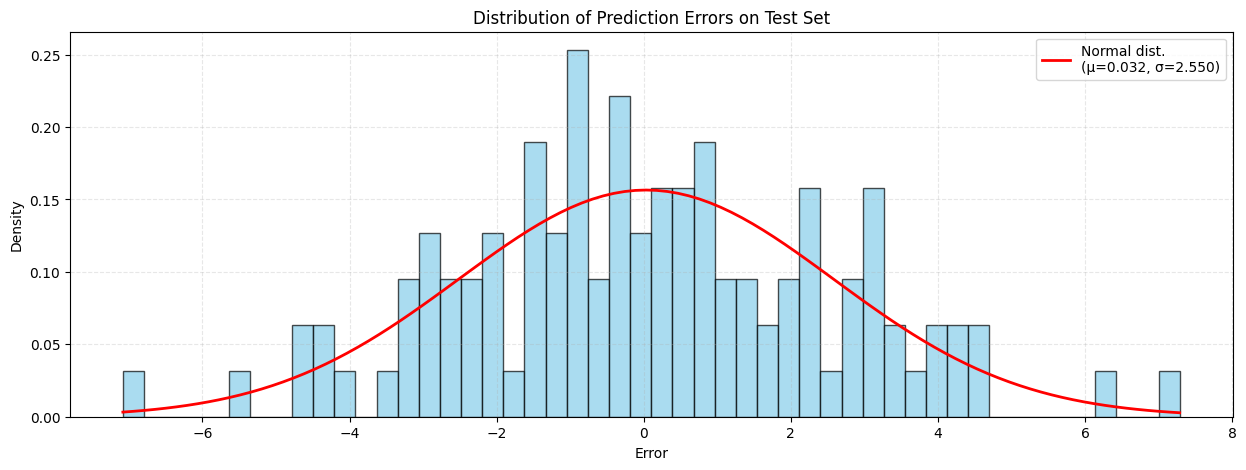

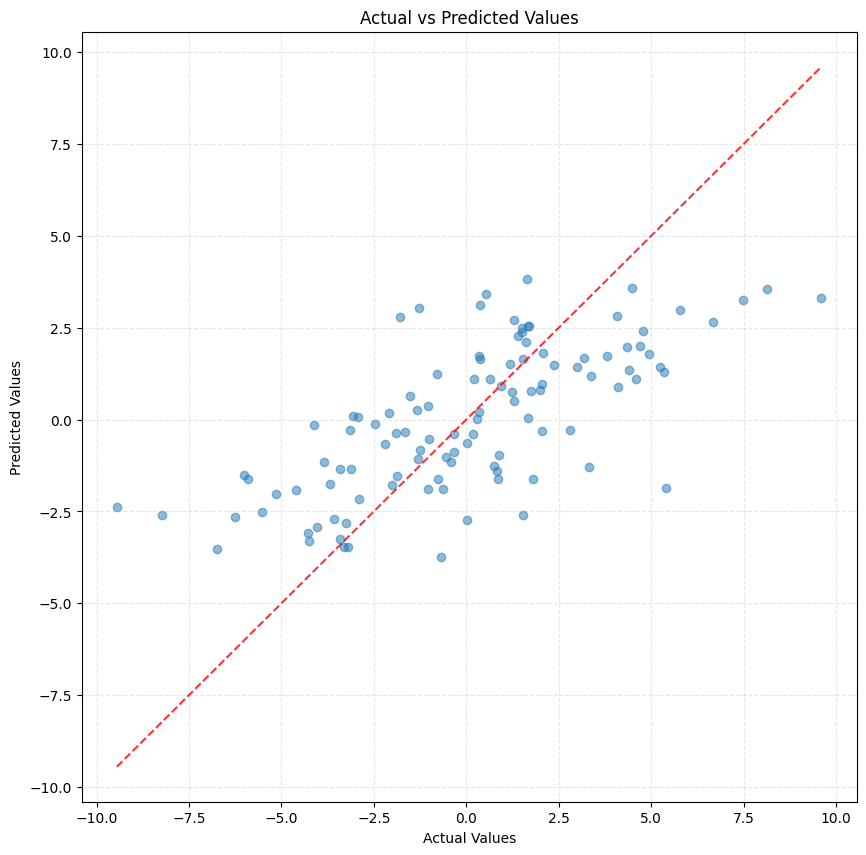

In [ ]:
# Plot the error distribution with fitted normal distribution
plt.figure(figsize=(15, 5))
errors = test - reconstructed[len(train)+len(validation):]

# Calculate mean and standard deviation
mu = np.mean(errors)
sigma = np.std(errors)

# Create histogram
counts, bins, _ = plt.hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)

# Generate points for the normal distribution curve
x = np.linspace(min(bins), max(bins), 100)
pdf = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2/(2*sigma**2))

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', lw=2, label=f'Normal dist.\n(μ={mu:.3f}, σ={sigma:.3f})')

plt.title('Distribution of Prediction Errors on Test Set')
plt.xlabel('Error')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.show()

# Plot actual vs predicted scatter
plt.figure(figsize=(10, 10))
plt.scatter(test, reconstructed[len(train)+len(validation):], alpha=0.5)
plt.plot([test.min(), test.max()], [test.min(), test.max()], 'r--', alpha=0.8) # Perfect prediction line
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
